# Heart Disease Analysis and Probability Prediction

## Reading, Loading and Storing in a Dataframe

Data Source:  UC Irvine Machine Learning Data Archive
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ 

### Steps for reproducing results in this notebook:

1) Make `data/` directory in the working directory

2) Run the following commands in the order:

```shell
$ curl -o data/cleveland14.csv http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data
$ curl -o data/hungarian14r.ssv http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data
$ curl -o data/switzerland14.csv http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data
$ curl -o data/long_beach_va14.csv http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data
$ python convert_ssv_to_csv.py data/hungarian14r
$ python join_files.py
```

3) The output of `join_files.py` is file `data/heart_disease_all14.csv` and is ready for processing by `Heart_Disease_Analysis_Complete.ipynb`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from typing import *

%matplotlib inline

List of available features:

 1. age: continuous
 2. sex: categorical, 2 values {0: female, 1: male}
 3. cp (chest pain type): categorical, 4 values
    {1: typical angina, 2: atypical angina, 3: non-angina, 4: asymptomatic angina}
 4. restbp (resting blood pressure on admission to hospital): continuous (mmHg)
 5. chol (serum cholesterol level): continuous (mg/dl)
 6. fbs (fasting blood sugar): categorical, 2 values {0: <= 120 mg/dl, 1: > 120 mg/dl}
 7. restecg (resting electrocardiography): categorical, 3 values
    {0: normal, 1: ST-T wave abnormality, 2: left ventricular hypertrophy}
 8. thalach (maximum heart rate achieved): continuous
 9. exang (exercise induced angina): categorical, 2 values {0: no, 1: yes}
10. oldpeak (ST depression induced by exercise relative to rest): continuous
11. slope (slope of peak exercise ST segment): categorical, 3 values 
    {1: upsloping, 2: flat, 3: downsloping}
12. ca (number of major vessels colored by fluoroscopy): discrete (0,1,2,3)
13. thal: categorical, 3 values {3: normal, 6: fixed defect, 7: reversible defect}
14. num (diagnosis of heart disease): categorical, 5 values 
    {0: less than 50% narrowing in any major vessel, 
    1-4: more than 50% narrowing in 1-4 vessels}
    
The actual number of feature variables (after converting categorical variables
to dummy ones) is: 
1 (age) + 1 (sex) + 3 (cp) + 1 (restbp) + 1 (chol) + 1 (fbs) + 2 (restecg) + 
1 (thalach) + 1 (exang) + 1 (oldpeak) + 2 (slope) + 1 (ca) + 2 (thal) = 18

The response variable (num) is categorical with 5 values, but we don't have
enough data to predict all the categories. Therefore we'll replace num with:
14. hd (heart disease): categorical, 2 values {0: no, 1: yes}

In [2]:
#Reading the data fron CSV file using pandas and creating Pandas dataframe.
columns = ["age", "sex", "cp", "restbp", "chol", "fbs", "restecg", 
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
df0 = pd.read_table("data/heart_disease_all14.csv", sep = ',', header = None, names = columns)

In [3]:
#Viewing first few rows of dataset
df0.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


In [4]:
#Computing mean,count,etc. characteristics
df0.describe()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.521739,0.67893,3.163880,131.715719,246.785953,0.143813,0.989967,149.327759,0.331104,1.058528,1.605351,0.672241,4.745819,0.946488
std,9.030264,0.46767,0.964069,17.747751,52.532582,0.351488,0.994903,23.121062,0.471399,1.162769,0.616962,0.937438,1.940977,1.230409
min,29.000000,0.00000,1.000000,94.000000,100.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.00000,3.000000,120.000000,211.000000,0.000000,0.000000,132.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.00000,3.000000,130.000000,242.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.00000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.00000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [5]:
#Checking the number of rows and columns in the dataset
df0.shape

(299, 14)

## Generating histograms for viewing distribution of values

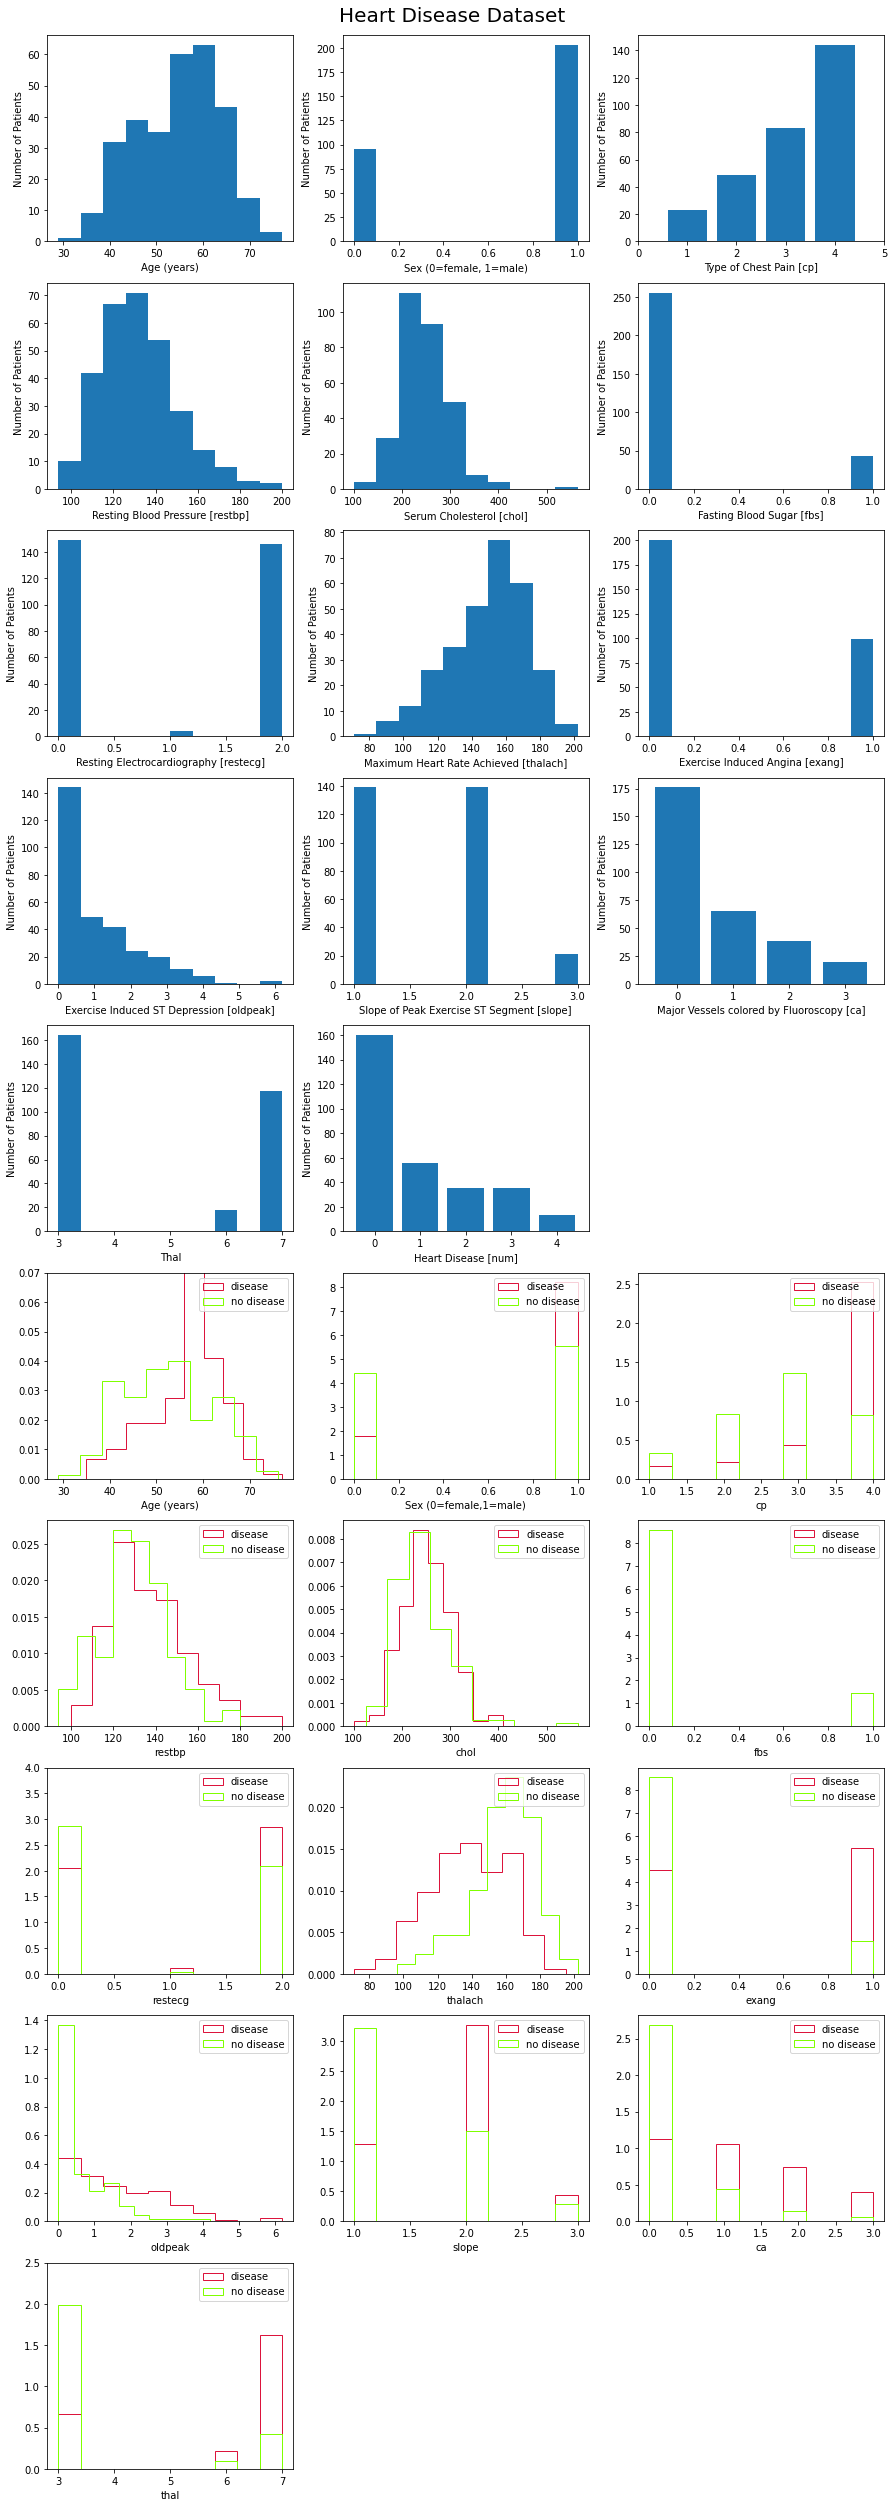

In [6]:
fig, axes = plt.subplots(nrows = 10, ncols = 3, figsize = (15,40))
plt.subplots_adjust(wspace = 0.20, hspace = 0.20, top = 0.97)
plt.suptitle("Heart Disease Dataset", fontsize = 20)

def configure_feature_ax(ax: plt.Axes, name: str, code: str = None, xlim: tuple[float, float] = None, ylim: tuple[float, float] = None) -> None:
    xlabel = name
    if not code is None:
        xlabel += " [" + code + "]"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Number of Patients")
    if not xlim is None:
        (x1, xn) = xlim
        ax.set_xlim(x1, xn)
    if not ylim is None:
        (y1, yn) = ylim
        ax.set_ylim(y1, yn)

axes[0, 0].hist(df0.age)
configure_feature_ax(axes[0, 0], "Age (years)")
axes[0, 1].hist(df0.sex)
configure_feature_ax(axes[0, 1], "Sex (0=female, 1=male)")
axes[0, 2].hist(df0.cp, bins = 4, range = (0.5, 4.5), rwidth = 0.80)
configure_feature_ax(axes[0, 2], "Type of Chest Pain", code = "cp", xlim = (0.0, 5.0))
axes[1, 0].hist(df0.restbp)
configure_feature_ax(axes[1, 0], "Resting Blood Pressure", code = "restbp")
axes[1, 1].hist(df0.chol)
configure_feature_ax(axes[1, 1], "Serum Cholesterol", code = "chol")
axes[1, 2].hist(df0.fbs)
configure_feature_ax(axes[1, 2], "Fasting Blood Sugar", code = "fbs")
axes[2, 0].hist(df0.restecg)
configure_feature_ax(axes[2, 0], "Resting Electrocardiography", code = "restecg")
axes[2, 1].hist(df0.thalach)
configure_feature_ax(axes[2, 1], "Maximum Heart Rate Achieved", code = "thalach")
axes[2, 2].hist(df0.exang)
configure_feature_ax(axes[2, 2], "Exercise Induced Angina", code = "exang")
axes[3, 0].hist(df0.oldpeak)
configure_feature_ax(axes[3, 0], "Exercise Induced ST Depression", code = "oldpeak")
axes[3, 1].hist(df0.slope)
configure_feature_ax(axes[3, 1], "Slope of Peak Exercise ST Segment", code = "slope")
axes[3, 2].hist(df0.ca, bins = 4, range = (-0.5, 3.5), rwidth = 0.8)
configure_feature_ax(axes[3, 2], "Major Vessels colored by Fluoroscopy", code = "ca", xlim = (-0.7, 3.7))
axes[4, 0].hist(df0.thal)
configure_feature_ax(axes[4, 0], "Thal")
axes[4, 1].hist(df0.num, bins = 5, range = (-0.5, 4.5), rwidth = 0.8)
configure_feature_ax(axes[4, 1], "Heart Disease", code = "num", xlim = (-0.7, 4.7))
axes[4, 2].axis("off")

def configure_disease_ax(ax: plt.Axes, name: str, data1: list[any], data2: list[any], xlim: tuple[float, float] = None, ylim: tuple[float, float] = None, bins: list[any] = None) -> None:
    xlabel = name
    if not bins is None:
        ax.hist(data1.tolist(), color = ["crimson"], histtype = "step", label = "disease", density = True)
        ax.hist(data2, color = ["chartreuse"], histtype = "step", label = "no disease", density = True)
    else:
        ax.hist(data1.tolist(), bins, color = ["crimson"], histtype = "step", label = "disease", density = True)
        ax.hist(data2, bins, color = ["chartreuse"], histtype = "step", label = "no disease", density = True)
    ax.set_xlabel(name)
    ax.legend(prop = {'size': 10}, loc = "upper right")
    if not xlim is None:
        (x1, xn) = xlim
        ax.set_xlim(x1, xn)
    if not ylim is None:
        (y1, yn) = ylim
        ax.set_ylim(y1, yn)

#Marginal Feature Distribution comapared for disease and not-disease\
configure_disease_ax(axes[5, 0], "Age (years)", df0[df0.num > 0].age, df0[df0.num == 0].age, bins = np.linspace(20, 80, 15), ylim = (0.0, 0.070))
configure_disease_ax(axes[5, 1], "Sex (0=female,1=male)", df0[df0.num > 0].sex, df0[df0.num == 0].sex)
configure_disease_ax(axes[5, 2], "cp", df0[df0.num > 0].cp, df0[df0.num == 0].cp)
configure_disease_ax(axes[6, 0], "restbp", df0[df0.num > 0].restbp, df0[df0.num == 0].restbp, bins = np.linspace(80, 200, 15))
configure_disease_ax(axes[6, 1], "chol", df0[df0.num > 0].chol, df0[df0.num == 0].chol)
configure_disease_ax(axes[6, 2], "fbs", df0[df0.num > 0].fbs, df0[df0.num == 0].fbs)
configure_disease_ax(axes[7, 0], "restecg", df0[df0.num > 0].restecg, df0[df0.num == 0].restecg, ylim = (0.0, 4.0))
configure_disease_ax(axes[7, 1], "thalach", df0[df0.num > 0].thalach, df0[df0.num == 0].thalach)
configure_disease_ax(axes[7, 2], "exang", df0[df0.num > 0].exang, df0[df0.num == 0].exang)
configure_disease_ax(axes[8, 0], "oldpeak", df0[df0.num > 0].oldpeak, df0[df0.num == 0].oldpeak)
configure_disease_ax(axes[8, 1], "slope", df0[df0.num > 0].slope, df0[df0.num == 0].slope)
configure_disease_ax(axes[8, 2], "ca", df0[df0.num > 0].ca, df0[df0.num == 0].ca)
configure_disease_ax(axes[9, 0], "thal", df0[df0.num > 0].thal, df0[df0.num == 0].thal, ylim = (0.0, 2.5))
axes[9, 1].axis("off")
axes[9, 2].axis("off")

plt.show()

In [7]:
#Converting categorial values into discrete values
#Note that feature ca is discrete but not categorical, so we don't convert it.
df = df0.copy()
dummies = pd.get_dummies(df["cp"], prefix = "cp")
df = df.join(dummies)
del df["cp"]
del df["cp_4.0"]
df = df.rename(columns = {"cp_1.0": "cp_1", "cp_2.0": "cp_2", "cp_3.0": "cp_3"})

dummies = pd.get_dummies(df["restecg"], prefix = "recg")
df = df.join(dummies)
del df["restecg"]
del df["recg_0.0"]
df = df.rename(columns = {"recg_1.0": "recg_1", "recg_2.0": "recg_2"})

dummies = pd.get_dummies(df["slope"], prefix = "slope")
df = df.join(dummies)
del df["slope"]
del df["slope_2.0"]
df = df.rename(columns = {"slope_1.0": "slope_1", "slope_3.0": "slope_3"})

dummies = pd.get_dummies(df["thal"], prefix = "thal")
df = df.join(dummies)
del df["thal"]
del df["thal_3.0"]
df = df.rename(columns = {"thal_6.0": "thal_6", "thal_7.0": "thal_7"})

#Replace response variable values and renaming it hd
#The num variable values of 1,2,3,4 are replaced with 1 in order to signify that the patient has heart disease
df["num"].replace(to_replace=[1, 2, 3, 4], value = 1, inplace = True)
df = df.rename(columns = {"num": "hd"})

new_columns_1 = ["age", "sex", "restbp", "chol", "fbs", "thalach", 
                 "exang", "oldpeak", "ca", "hd", "cp_1", "cp_2",
                 "cp_3", "recg_1", "recg_2", "slope_1", "slope_3",
                 "thal_6", "thal_7"]

print ('\nNumber of patients in dataframe: %i, with disease: %i, without disease: %i\n' \
      % (len(df.index), len(df[df.hd == 1].index), len(df[df.hd == 0].index)))
print (df.head())
print (df.describe())

# Standardize the dataframe
stdcols = ["age", "restbp", "chol", "thalach", "oldpeak"]
nrmcols = ["ca"]
stddf = df.copy()
stddf[stdcols] = stddf[stdcols].apply(lambda x: (x - x.mean()) / x.std())
stddf[nrmcols] = stddf[nrmcols].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

new_columns_2 = new_columns_1[:9] + new_columns_1[10:]
new_columns_2.insert(0,new_columns_1[9])
stddf = stddf.reindex(columns = new_columns_2)

# Convert dataframe into lists for use by classifiers
yall = stddf["hd"]
Xall = stddf[new_columns_2[1:]].values


Number of patients in dataframe: 299, with disease: 139, without disease: 160

    age  sex  restbp   chol  fbs  thalach  exang  oldpeak   ca   hd  cp_1  \
0  63.0  1.0   145.0  233.0  1.0    150.0    0.0      2.3  0.0  0.0     1   
1  67.0  1.0   160.0  286.0  0.0    108.0    1.0      1.5  3.0  1.0     0   
2  67.0  1.0   120.0  229.0  0.0    129.0    1.0      2.6  2.0  1.0     0   
3  37.0  1.0   130.0  250.0  0.0    187.0    0.0      3.5  0.0  0.0     0   
4  41.0  0.0   130.0  204.0  0.0    172.0    0.0      1.4  0.0  0.0     0   

   cp_2  cp_3  recg_1  recg_2  slope_1  slope_3  thal_6  thal_7  
0     0     0       0       1        0        1       1       0  
1     0     0       0       1        0        0       0       0  
2     0     0       0       1        0        0       0       1  
3     0     1       0       0        0        1       0       0  
4     1     0       0       1        1        0       0       0  
              age        sex      restbp        chol         

Note about logistic regression with scikit-learn:
-> In scikit-learn we can specify penalty="l1" or penalty="l2", with
  an associated C=c, which is the *inverse* of the regularization strength.
  Thus, for zero regularization specify a high value of c.  Scikit-learn
  does not calculate uncertainties on the fit coefficients.

In [8]:
lasso = False

nfeatures = len(stddf.columns)
if lasso:           # lasso regularization
    penalty = "l1"
    cval    = 1.0
    alpha   = [1.0]*nfeatures
else:               # no regularization
    penalty = "l1"
    cval    = 1000.0
    alpha   = 0.0

model = LogisticRegression(fit_intercept = True, penalty = penalty, dual = False, C = cval, solver = 'liblinear')
print(model)
lrfit = model.fit(Xall, yall)
print('\nLogisticRegression score on full data set: %f\n' % lrfit.score(Xall, yall))
ypred = model.predict(Xall)
print ('\nClassification report on full data set:')
print(metrics.classification_report(yall, ypred))
print ('\nConfusion matrix:')
print(metrics.confusion_matrix(yall, ypred))
print ('\nLogisticRegression coefficients:')
coeff = model.coef_.tolist()[0]
for index in range(len(coeff)):
    print('%s : %8.5f' % (new_columns_2[index + 1].rjust(9), coeff[index]))
print('Intercept : %f' % model.intercept_)

LogisticRegression(C=1000.0, penalty='l1', solver='liblinear')

LogisticRegression score on full data set: 0.872910


Classification report on full data set:
              precision    recall  f1-score   support

         0.0       0.86      0.91      0.88       160
         1.0       0.89      0.83      0.86       139

    accuracy                           0.87       299
   macro avg       0.88      0.87      0.87       299
weighted avg       0.87      0.87      0.87       299


Confusion matrix:
[[146  14]
 [ 24 115]]

LogisticRegression coefficients:
      age : -0.12373
      sex :  1.54814
   restbp :  0.43322
     chol :  0.22072
      fbs : -0.59493
  thalach : -0.41717
    exang :  0.71844
  oldpeak :  0.41982
       ca :  3.92905
     cp_1 : -2.10057
     cp_2 : -0.84579
     cp_3 : -1.85006
   recg_1 :  0.77478
   recg_2 :  0.46859
  slope_1 : -1.16416
  slope_3 : -0.64714
   thal_6 : -0.03076
   thal_7 :  1.40129
Intercept : -0.605054
